In [14]:
from test_utils import *
from blobmodel import BlobShapeEnum, BlobShapeImpl
import numpy as np
import cosmoplots as cp
from imaging_methods import *

plt.style.use(["cosmoplots.default"])
plt.rcParams["text.latex.preamble"] = (
    r"\usepackage{amsmath} \usepackage{mathptmx} \usepackage{amssymb} "
)


MAKE_PLOTS = True
T = 10000
Lx = 8
Ly = 8
nx = 8
ny = 8
dt = 0.1
bs = BlobShapeImpl(BlobShapeEnum.gaussian, BlobShapeEnum.gaussian)
K = 10000

# Method parameters
method_parameters = {
    "preprocessing": {"radius": 1000},
    "2dca": {
        "refx": 4,
        "refy": 4,
        "threshold": 2,
        "window": 60,
        "check_max": 1,
        "single_counting": True,
    },
    "gauss_fit": {"size_penalty": 5, "aspect_penalty": 0.2, "tilt_penalty": 0.2},
    "contouring": {
        "threshold_factor": 0.3,
        "threshold_factor_cc": 0.5,
        "com_smoothing": 10,
    },
    "taud_estimation": {"cutoff": 1e6, "nperseg": 1e3},
}

figures_dir = "integrated_tests_figures"

In [2]:
def movie(
    dataset: xr.Dataset,
    interval: int = 100,
    interpolation: str = "spline16",
    file_name=None,
) -> None:
    dt = get_dt(dataset)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    t_dim = "time"
    refx, refy = int(dataset["refx"].item()), int(dataset["refy"].item())

    contour_cc = get_contour_evolution(
        dataset.cross_corr,
        method_parameters["contouring"]["threshold_factor_cc"],
    )
    contour_ca = get_contour_evolution(
        dataset.cond_av,
        method_parameters["contouring"]["threshold_factor"],
    )
    max_ca = im.compute_maximum_trajectory_da(dataset, variable = "cond_av")
    max_cc = im.compute_maximum_trajectory_da(dataset, variable = "cross_corr")

    def get_title(i):
        time = dataset[t_dim][i]
        if dt < 1e-3:
            title = r"t$={:.2f}\,\mu$s".format(time * 1e6)
        else:
            title = r"t$={:.2f}\,$s".format(time)
        return title

    def animate_2d(i: int):
        arr0 = dataset.cond_av.isel(**{t_dim: i})
        arr1 = dataset.cross_corr.isel(**{t_dim: i})
        im0.set_data(arr0)
        im0.set_clim(0, np.max(dataset.cond_av.values))
        im1.set_data(arr1)
        im1.set_clim(0, np.max(dataset.cross_corr.values))

        c0 = contour_ca.contours.isel(time=i).data
        c1 = contour_cc.contours.isel(time=i).data
        line0[0].set_data(c0[:, 0], c0[:, 1])
        line1[0].set_data(c1[:, 0], c1[:, 1])
        com_scatter0.set_offsets(contour_ca.center_of_mass.values[i, :])
        com_scatter1.set_offsets(contour_cc.center_of_mass.values[i, :])
        max_scatter0.set_offsets(max_ca.values[i, :])
        max_scatter1.set_offsets(max_cc.values[i, :])

        tx.set_text(get_title(i))

    # tx = ax[0].set_title(get_title(0))
    tx = fig.suptitle(get_title(0))
    ax[0].set_title("Cond. Av.")
    ax[1].set_title("Cross Corr.")
    ax[0].scatter(
        dataset.R.isel(x=refx, y=refy).item(),
        dataset.Z.isel(x=refx, y=refy).item(),
        color="black",
    )
    ax[1].scatter(
        dataset.R.isel(x=refx, y=refy).item(),
        dataset.Z.isel(x=refx, y=refy).item(),
        color="black",
    )
    div0 = make_axes_locatable(ax[0])
    div1 = make_axes_locatable(ax[1])
    cax0 = div0.append_axes("right", "5%", "5%")
    cax1 = div1.append_axes("right", "5%", "5%")
    im0 = ax[0].imshow(
        dataset.cond_av.isel(**{t_dim: 0}),
        origin="lower",
        interpolation=interpolation,
    )
    im1 = ax[1].imshow(
        dataset.cross_corr.isel(**{t_dim: 0}),
        origin="lower",
        interpolation=interpolation,
    )
    com_scatter0 = ax[0].scatter(
        contour_ca.center_of_mass.values[0, 0],
        contour_ca.center_of_mass.values[0, 1],
        marker="s",
        color="green",
    )
    com_scatter1 = ax[1].scatter(
        contour_cc.center_of_mass.values[0, 0],
        contour_cc.center_of_mass.values[0, 1],
        marker="s",
        color="green",
    )
    max_scatter0 = ax[0].scatter(
        max_ca.values[0, 0], max_ca.values[0, 1], marker="^", color="orange"
    )
    max_scatter1 = ax[1].scatter(
        max_cc.values[0, 0], max_cc.values[0, 1], marker="^", color="orange"
    )
    line0 = ax[0].plot([], [], ls="--", color="black")
    line1 = ax[1].plot([], [], ls="--", color="black")
    fig.colorbar(im0, cax=cax0)
    fig.colorbar(im1, cax=cax1)

    im0.set_extent(
        (dataset.R[0, 0], dataset.R[0, -1], dataset.Z[0, 0], dataset.Z[-1, 0])
    )
    im1.set_extent(
        (dataset.R[0, 0], dataset.R[0, -1], dataset.Z[0, 0], dataset.Z[-1, 0])
    )

    ani = animation.FuncAnimation(
        fig, animate_2d, frames=dataset[t_dim].values.size, interval=interval
    )

    if file_name is not None:
        ani.save(file_name, writer="ffmpeg", fps=10)
        os.system(
            "gifsicle -i {} -O3 --colors 32 --lossy=150 -o {}".format(
                file_name, file_name
            )
        )

    plt.show()

In [15]:
def get_synthetic_data():
    alpha = np.pi / 8
    vx_input = np.cos(alpha)
    vy_intput = np.sin(alpha)
    lx_input = 1
    ly_input = 1
    theta_input = 0

    ds = make_2d_realization(
        Lx,
        Ly,
        T,
        nx,
        ny,
        dt,
        K,
        vx=vx_input,
        vy=vy_intput,
        lx=lx_input,
        ly=ly_input,
        theta=theta_input,
        bs=bs,
    )
    ds = im.run_norm_ds(ds, method_parameters["preprocessing"]["radius"])
    return ds


def make_decoherence_realization(rand_coeff):
    def blob_getter():
        return get_blob(
            amplitude=np.random.exponential(),
            vx=np.random.uniform(1 - rand_coeff, 1 + rand_coeff),
            vy=np.random.uniform(-rand_coeff, rand_coeff),
            posx=np.random.uniform(0, Lx),
            posy=np.random.uniform(0, Ly),
            lx=1,
            ly=1,
            t_init=np.random.uniform(0, T),
            bs=bs,
            theta=0,  # 0 but go to the != 0 branch in the blob.py function
        )

    ds = make_2d_realization(
        Lx,
        Ly,
        T,
        nx,
        ny,
        dt,
        K,
        vx=0,  # velocities are overriden
        vy=0,
        lx=1,
        ly=1,
        theta=0,
        bs=bs,
        blob_getter=blob_getter,
    )
    ds = im.run_norm_ds(ds, method_parameters["preprocessing"]["radius"])
    return ds


def get_velocities_from_position(average_ds, contour, position, delta, extra_mask=None):
    velocity_ds = im.get_contour_velocity(
        position,
        method_parameters["contouring"]["com_smoothing"],
    )
    v, w = im.get_average_velocity_for_near_com(
        average_ds, contour, velocity_ds, distance=delta, extra_mask=extra_mask
    )
    return v, w

In [25]:
shot = 1160616027
manager = im.GPIDataAccessor(
    "/media/fusion/fusion-files/jlo044/experimental_database/plasma_discharges.json"
)
# ds = manager.read_shot_data(shot, preprocessed=True, data_folder="../data")
ds = make_decoherence_realization(1)

tdca_params = method_parameters["2dca"]
events, average_ds = im.find_events_and_2dca(
        ds,
        tdca_params["refx"],
        tdca_params["refy"],
        threshold=tdca_params["threshold"],
        check_max=tdca_params["check_max"],
        window_size=tdca_params["window"],
        single_counting=tdca_params["single_counting"],
    )

Summing up Blobs: 100%|████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 220.44it/s]


Found 365 events
Discarded 151 events. Not max 126, zero len 0, truncation 1, single count 24


In [13]:
tdca_params

{'refx': 4,
 'refy': 4,
 'threshold': 2,
 'window': 60,
 'check_max': 1,
 'single_counting': True}

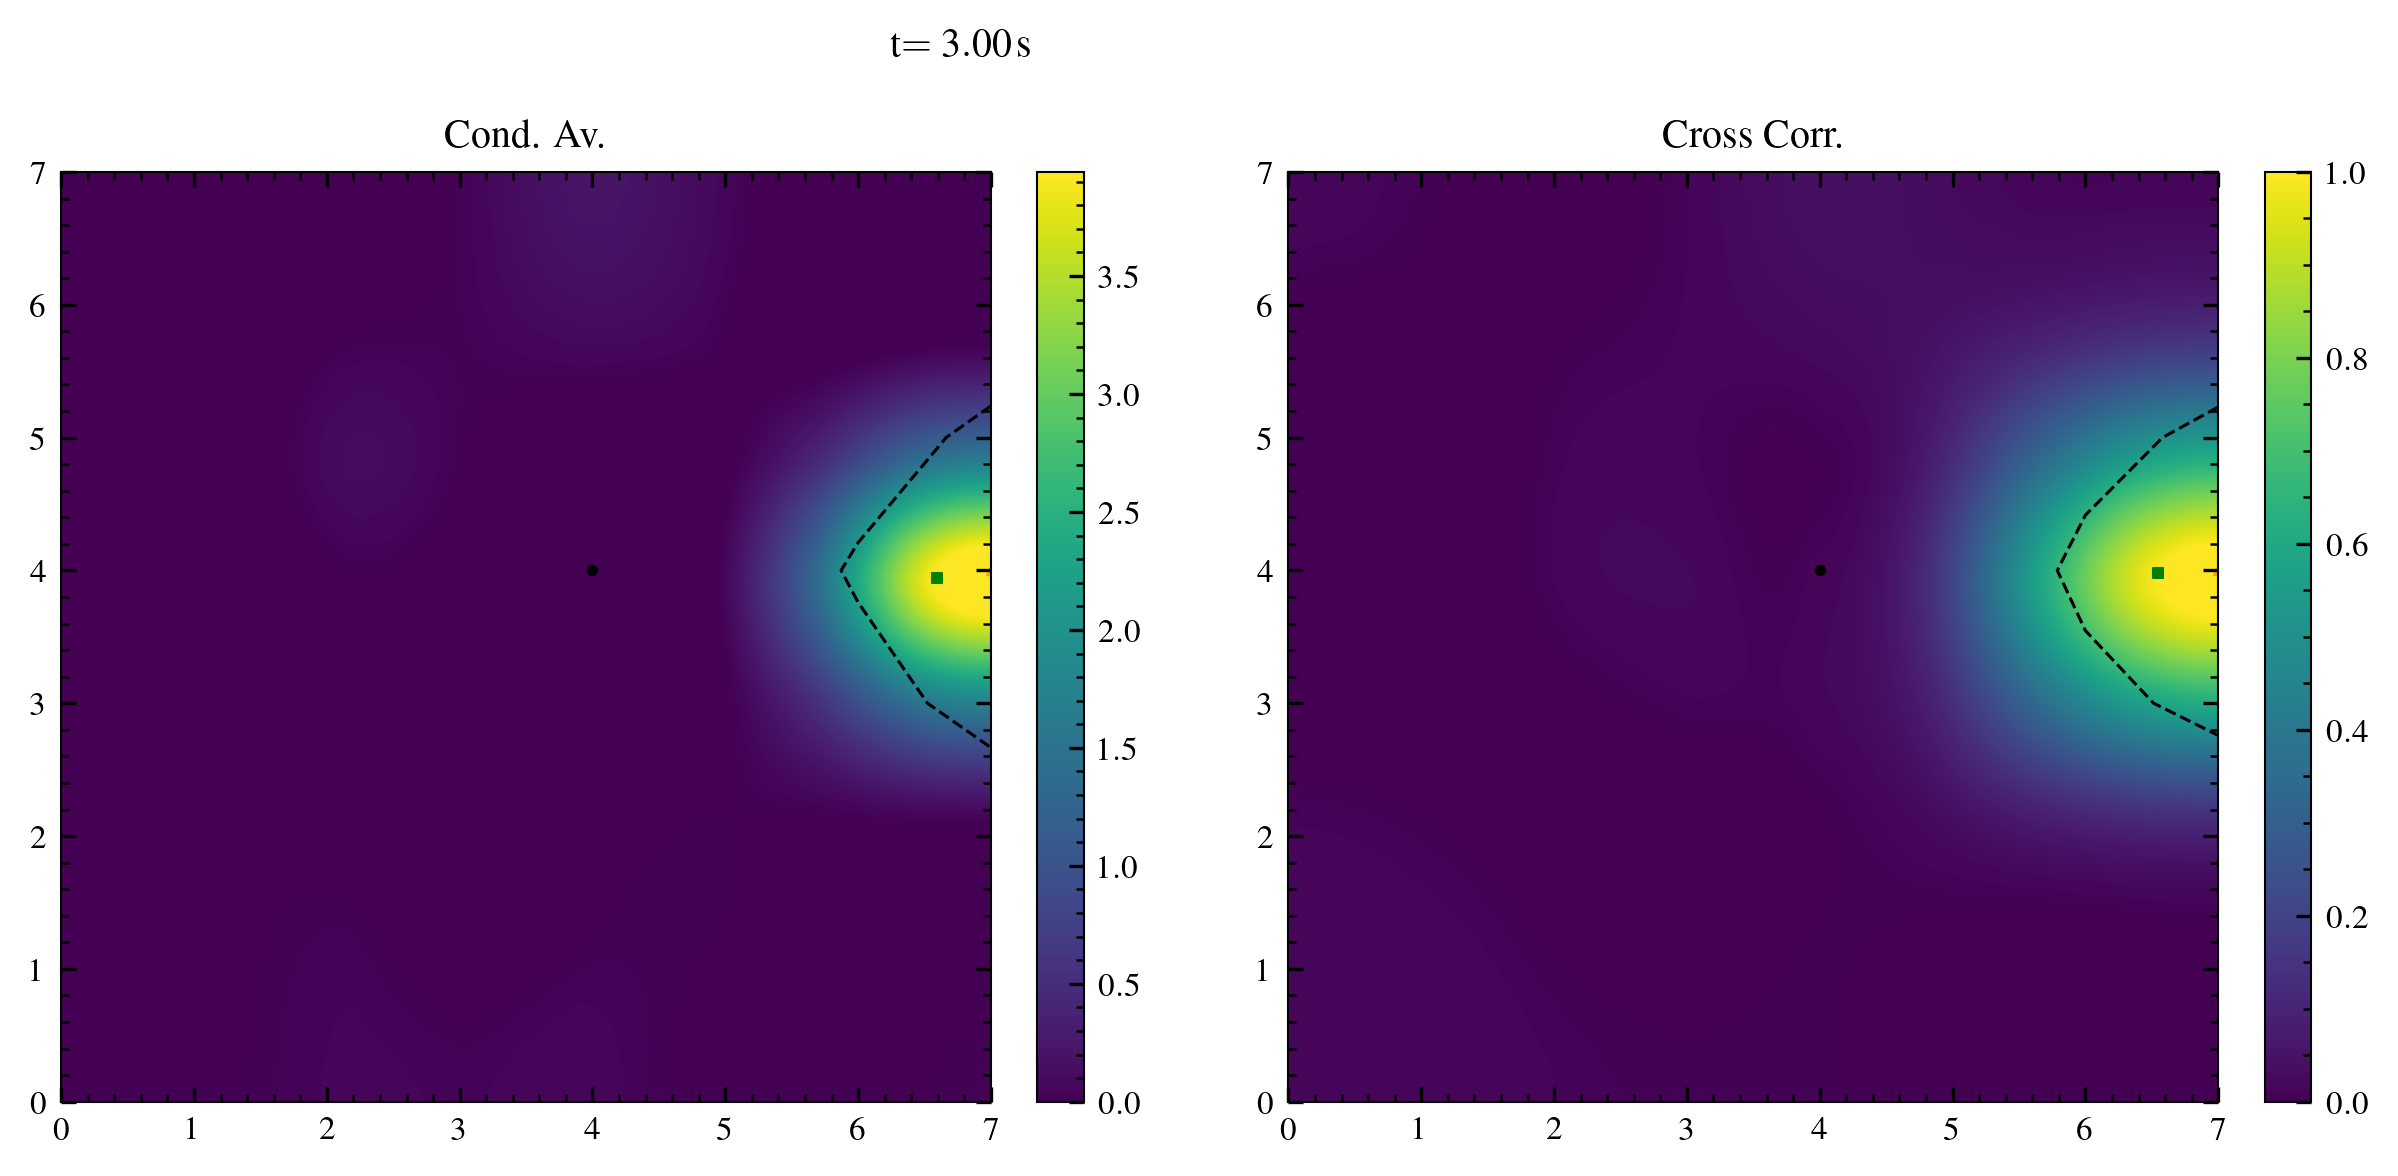

In [17]:
movie(average_ds, file_name="trajectories.gif")

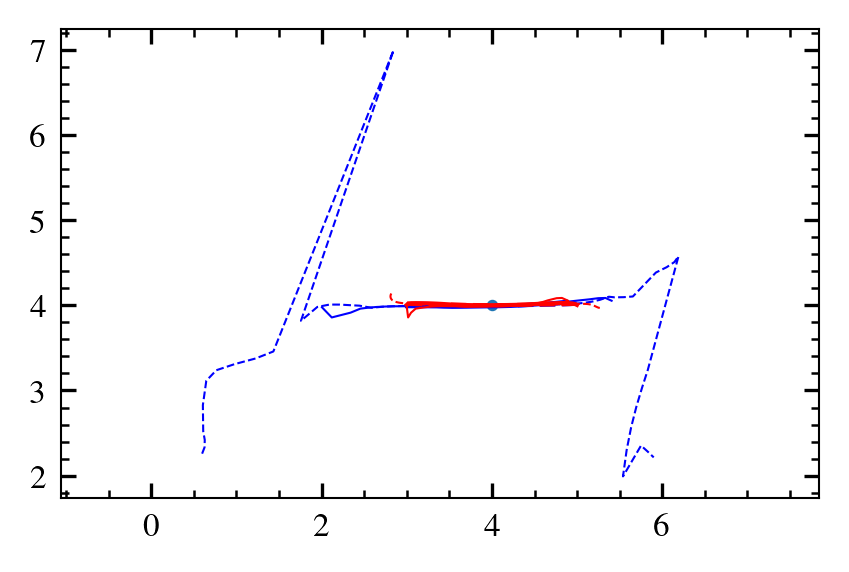

Ca centroid: 0.0106, 0.00
Ca max: 0.0106, 0.00
Cc centroid: 0.0065, 0.00
Cc max: 0.0068, -0.00


In [29]:
method = "fit"
cond_av_max = im.compute_maximum_trajectory_da(average_ds, "cond_av", method=method)
cross_corr_max = im.compute_maximum_trajectory_da(average_ds, "cross_corr", method=method)
refx, refy = tdca_params["refx"], tdca_params["refy"]
delta = average_ds.R.isel(x=refx, y=refy).item() - average_ds.R.isel(x=refx - 1, y=refy).item()
contour_ca = im.get_contour_evolution(
    average_ds.cond_av,
    method_parameters["contouring"]["threshold_factor"],
    max_displacement_threshold=None,
    com_method="centroid",
)
cond_av_centroid = contour_ca.center_of_mass
contour_cc = im.get_contour_evolution(
    average_ds.cross_corr,
    method_parameters["contouring"]["threshold_factor_cc"],
    max_displacement_threshold=None,
    com_method="centroid",
)
ca_max = average_ds.cond_av.max(dim=["x", "y"]).values
cc_max = average_ds.cross_corr.max(dim=["x", "y"]).values

cross_corr_centroid = contour_cc.center_of_mass

def get_good_times(position, signal):
    filter = signal > 0.5*np.max(signal)
    filter = restrict_to_largest_true_subarray(filter)
    distances_vector = position.values - [R, Z]
    distances = np.sqrt((distances_vector ** 2).sum(axis=1))
    mask = distances < delta
    return np.logical_and(mask, filter)

def get_velocity(position, mask):
    velocity_ds = im.get_contour_velocity(
        position,
        method_parameters["contouring"]["com_smoothing"],
    )
    mask = get_good_times(position, ca_max)
    valid_times = position.time[mask]  # DataArray with wanted times
    common_times = valid_times[valid_times.isin(velocity_ds.time)]
    v, w = velocity_ds.sel(time=common_times).mean(dim="time", skipna=True).values
    return v, w
    
fig, ax = plt.subplots()

R, Z = (
    ds.R.isel(x=tdca_params["refx"], y=tdca_params["refy"]).item(),
    ds.Z.isel(x=tdca_params["refx"], y=tdca_params["refy"]).item(),
)


ax.scatter(R, Z)

mask_ca_centroid = get_good_times(cond_av_centroid, ca_max)
mask_ca_max = get_good_times(cond_av_max, ca_max)
mask_cc_centroid = get_good_times(cross_corr_centroid, cc_max)
mask_cc_max = get_good_times(cross_corr_max, cc_max)

ax.plot(cond_av_centroid.values[:, 0], cond_av_centroid.values[:, 1], color="blue", lw=0.5)
ax.plot(cond_av_centroid.values[:, 0][mask_ca_centroid], cond_av_centroid.values[:, 1][mask_ca_centroid], color="blue", lw=1)

ax.plot(cond_av_max.values[:, 0], cond_av_max.values[:, 1], color="blue", ls="--", lw=0.5)
ax.plot(cond_av_max.values[:, 0][mask_ca_max], cond_av_max.values[:, 1][mask_ca_max], color="blue", ls = "--", lw=1)

ax.plot(
    cross_corr_centroid.values[:, 0], cond_av_centroid.values[:, 1], color="red", lw=0.5
)

ax.plot(cross_corr_centroid.values[:, 0][mask_cc_centroid], cross_corr_centroid.values[:, 1][mask_cc_centroid], color="red", lw=1)

ax.plot(
    cross_corr_max.values[:, 0], cross_corr_max.values[:, 1], color="red", ls="--", lw=0.5
)
ax.plot(cross_corr_max.values[:, 0][mask_cc_max], cross_corr_max.values[:, 1][mask_cc_max], color="red", ls = "--", lw=1)

ax.set_aspect('equal', adjustable='datalim')
plt.savefig("trajectories.pdf", bbox_inches="tight")
plt.show()

v_ca_centroid, w_ca_centroid = get_velocity(cond_av_centroid, mask_ca_centroid)
v_ca_max, w_ca_max = get_velocity(cond_av_max, mask_ca_max)
v_cc_centroid, w_cc_centroid = get_velocity(cross_corr_centroid, mask_cc_centroid)
v_cc_max, w_cc_max = get_velocity(cross_corr_max, mask_cc_max)

print(
    "Ca centroid: {:.4f}, {:.2f}".format(v_ca_centroid / 100, w_ca_centroid / 100)
)
print("Ca max: {:.4f}, {:.2f}".format(v_ca_max / 100, w_ca_max / 100))
print(
    "Cc centroid: {:.4f}, {:.2f}".format(v_cc_centroid / 100, w_cc_centroid / 100)
)
print("Cc max: {:.4f}, {:.2f}".format(v_cc_max / 100, w_cc_max / 100))

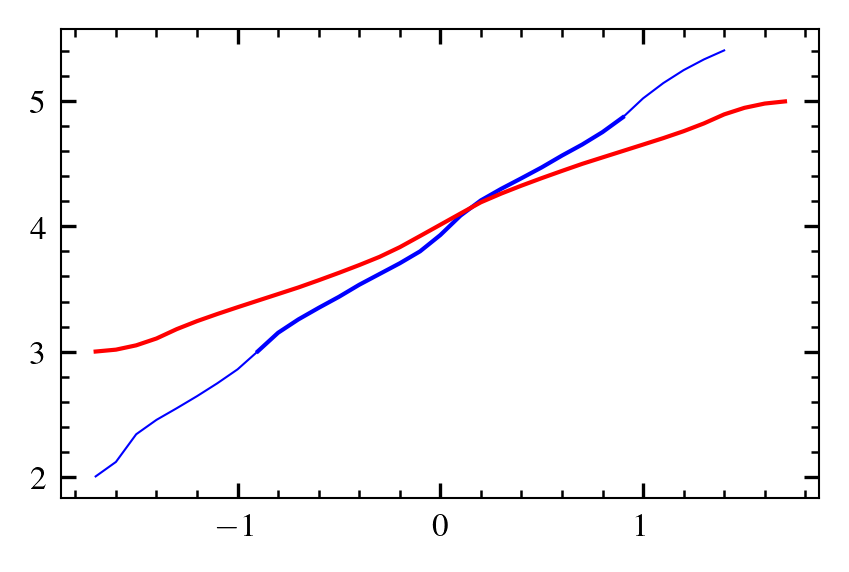

In [28]:
fig, ax = plt.subplots()
index = 0

ax.plot(average_ds.time.values, cond_av_centroid[:, index], color="blue", lw=0.5)
ax.plot(average_ds.time.values[mask_ca_centroid], cond_av_centroid[:, index][mask_ca_centroid], color="blue", lw=1)

ax.plot(average_ds.time.values, cross_corr_centroid[:, index], color="red", lw=0.5)
ax.plot(average_ds.time.values[mask_cc_centroid], cross_corr_centroid[:, index][mask_cc_centroid], color="red", lw=1)

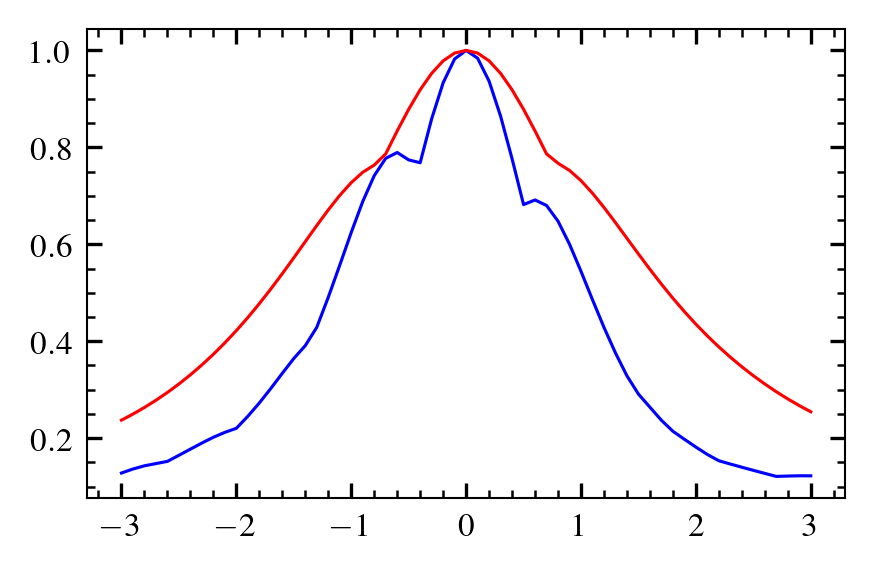

In [30]:
fig, ax = plt.subplots()

ax.plot(average_ds.time.values, ca_max/np.max(ca_max), color="blue")
ax.plot(average_ds.time.values, cc_max, color="red")

In [54]:
# average_ds.cross_corr.isel(x=refx, y=refy).values

import scipy.signal as ssi

half_window = 30
start_idx = ds.sizes["time"] - half_window
end_idx = ds.sizes["time"] + half_window + 1

ref_ts = ds.frames.isel(x=refx, y=refy).values
pixel = ds.frames.isel(x=refx, y=refy).values

ref_ts = (ref_ts - ref_ts.mean()) / ref_ts.std()
pixel = (pixel - pixel.mean()) / pixel.std()

cov_sums_full = ssi.correlate(pixel, ref_ts, mode="full")

cov_sums_full[start_idx:end_idx]/len(ref_ts)
np.max(cov_sums_full/ref_ts.size)

0.9999999999999997

In [19]:
def restrict_to_largest_true_subarray(mask):
    """
    Restrict the True values in the mask to the range of the longest consecutive True subarray.
    
    Parameters:
        mask (np.ndarray): A boolean array.
    
    Returns:
        np.ndarray: A new boolean mask with True values only in the range of the longest consecutive True subarray.
    """
    # Convert the boolean array to integers (True -> 1, False -> 0)
    mask_int = mask.astype(int)
    
    # Find the start and end indices of the longest consecutive True subarray
    diff = np.diff(np.concatenate(([0], mask_int, [0])))  # Add padding to detect edges
    starts = np.where(diff == 1)[0]  # Indices where True starts
    ends = np.where(diff == -1)[0]   # Indices where True ends
    
    # Calculate lengths of consecutive True segments
    lengths = ends - starts
    
    if len(lengths) == 0:
        # No True values in the mask
        return np.zeros_like(mask, dtype=bool)
    
    # Find the range of the longest consecutive True subarray
    max_index = lengths.argmax()
    start_idx = starts[max_index]
    end_idx = ends[max_index] - 1  # End index is inclusive
    
    # Create a new mask with True values only in the range [start_idx, end_idx]
    restricted_mask = np.zeros_like(mask, dtype=bool)
    restricted_mask[start_idx:end_idx + 1] = True
    
    return restricted_mask